--- 正在过滤极端值 ---
只保留 'meantime' 低于 95th 百分位数的数据。
截止值 (Cutoff Value): 83.16 (units)
--- 正在为 12 个 'genre' 生成“放大后”的图表 ---


C:\Users\50590\AppData\Local\Temp\ipykernel_16448\2739558073.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


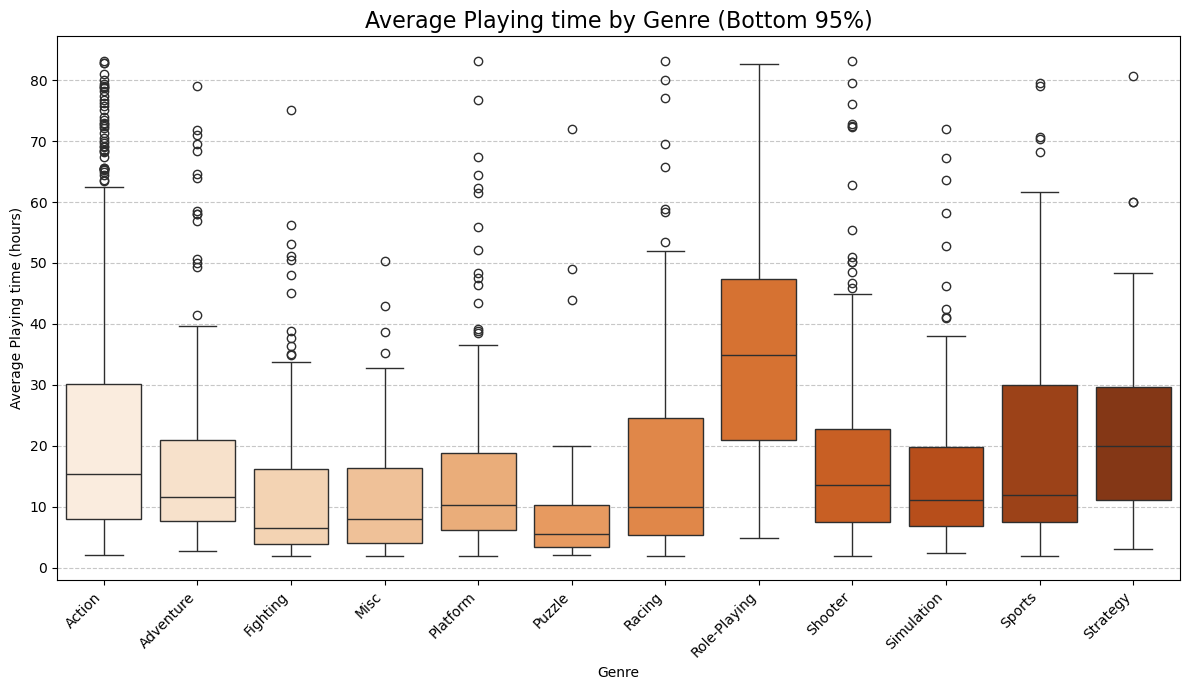

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 导入 seaborn 库

# -----------------------------------------------------------------
# 步骤1: 重置/检查字体设置
# -----------------------------------------------------------------
plt.rcParams.update(plt.rcParamsDefault)


def plot_boxplot_zoomed_in(file_path, min_sample_size=20, percentile_cutoff=0.95):
    """
    加载数据并绘制一个“放大”的箱形图，
    只显示低于95百分位数的 'meantime' 数据。
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"错误：找不到文件 '{file_path}'")
        return
    except Exception as e:
        print(f"加载CSV时出错: {e}")
        return

    # --- 1. 数据清洗和准备 (针对 'meantime') ---
    df['meantime'] = pd.to_numeric(df['meantime'], errors='coerce')
    df_clean = df[['genre', 'meantime']].dropna()

    # --- 2. 筛选出样本量足够的组 (逻辑同前) ---
    genre_counts = df_clean['genre'].value_counts()
    valid_genres = genre_counts[genre_counts >= min_sample_size].index
    
    if len(valid_genres) < 2:
        print(f"Error: Less than two 'genre' groups found with sample size >= {min_sample_size}.")
        return

    df_filtered = df_clean[df_clean['genre'].isin(valid_genres)]
    
    # -----------------------------------------------------------------
    # 步骤3: 新增！计算并应用截止值以“放大”
    # -----------------------------------------------------------------
    # 计算所有 'meantime' 数据的第95百分位数
    cutoff_value = df_filtered['meantime'].quantile(percentile_cutoff)
    
    print(f"--- 正在过滤极端值 ---")
    print(f"只保留 'meantime' 低于 {percentile_cutoff*100:.0f}th 百分位数的数据。")
    print(f"截止值 (Cutoff Value): {cutoff_value:.2f} (units)")
    
    # 创建一个新的 DataFrame，只包含“非极端”的数据
    df_zoomed = df_filtered[df_filtered['meantime'] <= cutoff_value]
    
    if df_zoomed.empty:
        print("错误：过滤后没有数据。请尝试更高的 'percentile_cutoff' (例如 0.99)。")
        return
    # -----------------------------------------------------------------

    # 按字母排序以获得一致的图表顺序
    df_zoomed = df_zoomed.sort_values('genre')

    print(f"--- 正在为 {len(valid_genres)} 个 'genre' 生成“放大后”的图表 ---")

    # --- 绘制美化后的箱形图 (Box Plot) ---
    plt.figure(figsize=(12, 7)) # 创建一个新画布
    
    sns.boxplot(
        x='genre', 
        y='meantime',
        data=df_zoomed,     # <-- 核心改动：使用过滤后的数据
        palette='Oranges'  
    )
    
    # --- 设置全英文标签 (更新标题) ---
    title_text = f'Average Playing time by Genre (Bottom {percentile_cutoff*100:.0f}%)'
    plt.title(title_text, fontsize=16)
    plt.ylabel('Average Playing time (hours)') # Y轴：时长
    plt.xlabel('Genre')            # X轴：类型
    
    plt.xticks(rotation=45, ha='right') 
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show() # 显示图表

# --- 执行 ---
# (请确保 'comdata.csv' 和您的脚本在同一目录下)
# 我们将 percentile_cutoff 设置为 0.95, 意为 "移除最高的5%"
plot_boxplot_zoomed_in('comdata.csv', percentile_cutoff=0.95)

--- 正在为 12 个 'genre' 生成相关性图表 ---


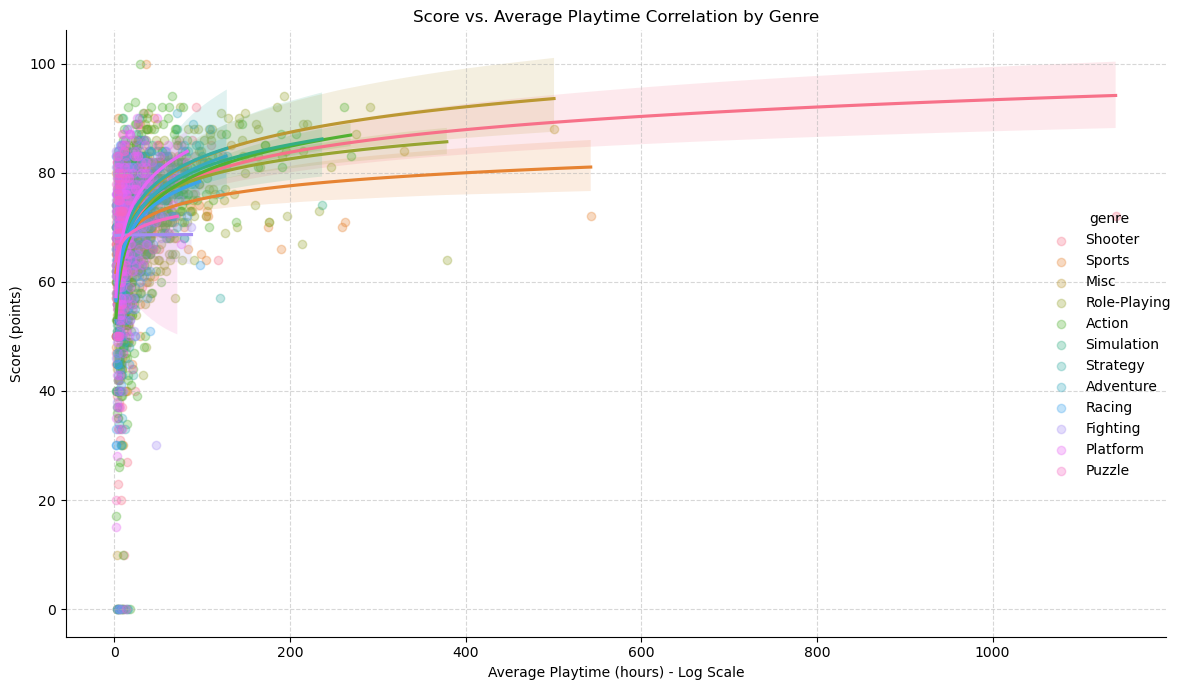

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# -----------------------------------------------------------------
# 重置字体设置
# -----------------------------------------------------------------
plt.rcParams.update(plt.rcParamsDefault)


def plot_score_vs_meantime_correlation(file_path, min_sample_size=20):
    """
    绘制 'score' vs 'meantime' 的相关性散点图。
    - 按 'genre' 着色
    - 为每个 'genre' 绘制单独的趋势线
    - X轴使用对数刻度 (log scale)
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"错误：找不到文件 '{file_path}'")
        return
    except Exception as e:
        print(f"加载CSV时出错: {e}")
        return

    # --- 1. 数据清洗和准备 ---
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df['meantime'] = pd.to_numeric(df['meantime'], errors='coerce')
    
    # 我们需要两列都不为空
    df_clean = df[['genre', 'score', 'meantime']].dropna()

    # --- 2. 筛选出样本量足够的组 ---
    genre_counts = df_clean['genre'].value_counts()
    valid_genres = genre_counts[genre_counts >= min_sample_size].index
    
    if len(valid_genres) < 2:
        print(f"Error: Less than two 'genre' groups found with sample size >= {min_sample_size}.")
        return

    df_filtered = df_clean[df_clean['genre'].isin(valid_genres)]

    print(f"--- 正在为 {len(valid_genres)} 个 'genre' 生成相关性图表 ---")

    # --- 绘制 lmplot (散点图 + 趋势线) ---
    
    # lmplot 是一个“重量级”函数，它会自己创建一个画布
    # logx=True 是这里的关键，它自动处理 'meantime' 的极端值
    g = sns.lmplot(
        data=df_filtered,
        x='meantime',
        y='score',
        hue='genre',      # <-- 按 'genre' 涂色
        logx=True,        # <-- 关键：X轴使用对数刻度
        height=7,
        aspect=1.5,
        scatter_kws={'alpha':0.3} # 让点半透明，防止重叠
    )
    
    # --- 设置英文标签 ---
    g.set(
        title='Score vs. Average Playtime Correlation by Genre',
        xlabel='Average Playtime (hours) - Log Scale', # X轴
        ylabel='Score (points)'                 # Y轴
    )
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show() # 显示图表

# --- 执行 ---
plot_score_vs_meantime_correlation('comdata.csv')

--- 正在过滤极端值 ---
只保留 'meantime' 低于 83.16 (units) 的数据。
--- 正在为 12 个 'genre' 生成“放大后”的相关性图表 ---


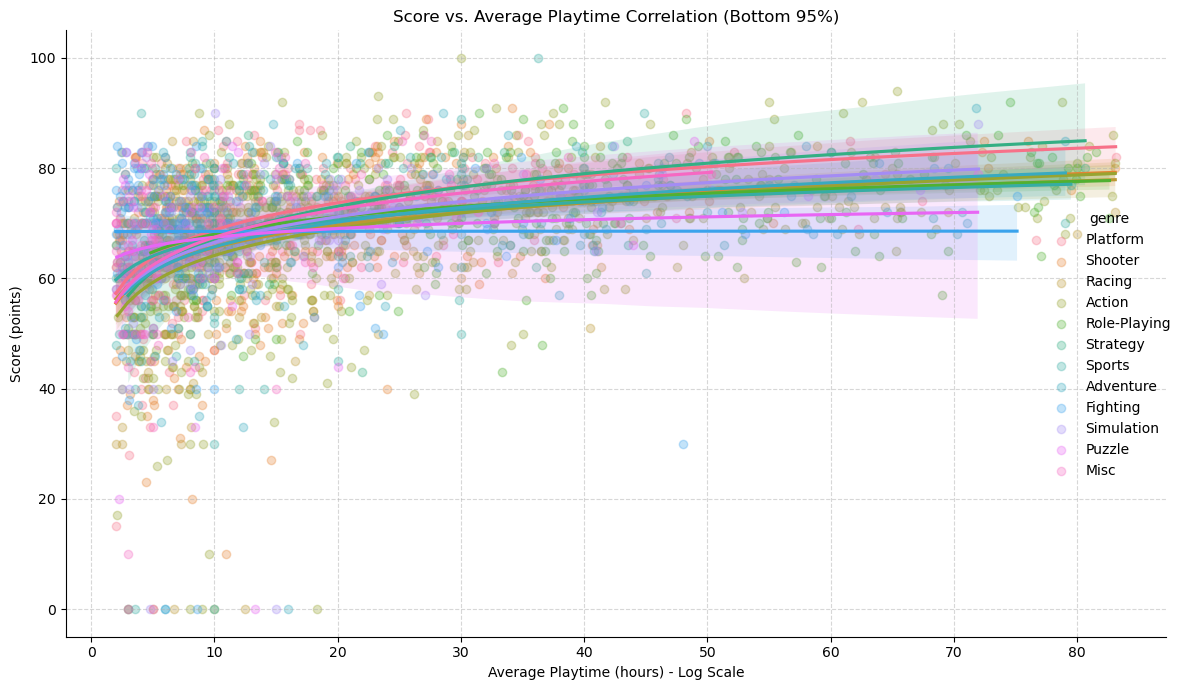

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# -----------------------------------------------------------------
# 重置字体设置
# -----------------------------------------------------------------
plt.rcParams.update(plt.rcParamsDefault)


def plot_zoomed_in_correlation(file_path, min_sample_size=20, percentile_cutoff=0.95):
    """
    绘制“放大版”的 'score' vs 'meantime' 相关性散点图。
    - 过滤掉最高的 5% 的 'meantime' 极端值
    - X轴仍使用对数刻度 (log scale)
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"错误：找不到文件 '{file_path}'")
        return
    except Exception as e:
        print(f"加载CSV时出错: {e}")
        return

    # --- 1. 数据清洗和准备 ---
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df['meantime'] = pd.to_numeric(df['meantime'], errors='coerce')
    df_clean = df[['genre', 'score', 'meantime']].dropna()

    # --- 2. 筛选出样本量足够的组 ---
    genre_counts = df_clean['genre'].value_counts()
    valid_genres = genre_counts[genre_counts >= min_sample_size].index
    
    if len(valid_genres) < 2:
        print(f"Error: Less than two 'genre' groups found with sample size >= {min_sample_size}.")
        return

    df_filtered = df_clean[df_clean['genre'].isin(valid_genres)]

    # --- 3. 新增！计算并应用截止值以“放大” ---
    cutoff_value = df_filtered['meantime'].quantile(percentile_cutoff)
    print(f"--- 正在过滤极端值 ---")
    print(f"只保留 'meantime' 低于 {cutoff_value:.2f} (units) 的数据。")
    
    # 创建一个新的 DataFrame，只包含“非极端”的数据
    df_zoomed = df_filtered[df_filtered['meantime'] <= cutoff_value]

    if df_zoomed.empty:
        print("错误：过滤后没有数据。")
        return

    print(f"--- 正在为 {len(valid_genres)} 个 'genre' 生成“放大后”的相关性图表 ---")

    # --- 绘制 lmplot (使用 'df_zoomed' 数据) ---
    g = sns.lmplot(
        data=df_zoomed,     # <-- 核心改动：使用过滤后的数据
        x='meantime',
        y='score',
        hue='genre',      
        logx=True,        # <-- 仍然使用对数刻度，以看清 0-160 范围的细节
        height=7,
        aspect=1.5,
        scatter_kws={'alpha':0.3} 
    )
    
    # --- 设置英文标签 (更新标题) ---
    title_text = f'Score vs. Average Playtime Correlation (Bottom {percentile_cutoff*100:.0f}%)'
    g.set(
        title=title_text,
        xlabel='Average Playtime (hours) - Log Scale', 
        ylabel='Score (points)'                 
    )
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show() # 显示图表

# --- 执行 ---
plot_zoomed_in_correlation('comdata.csv', percentile_cutoff=0.95)

--- 正在为 *所有* 2640 个游戏生成 *橙色主题* 总体相关性图表 ---


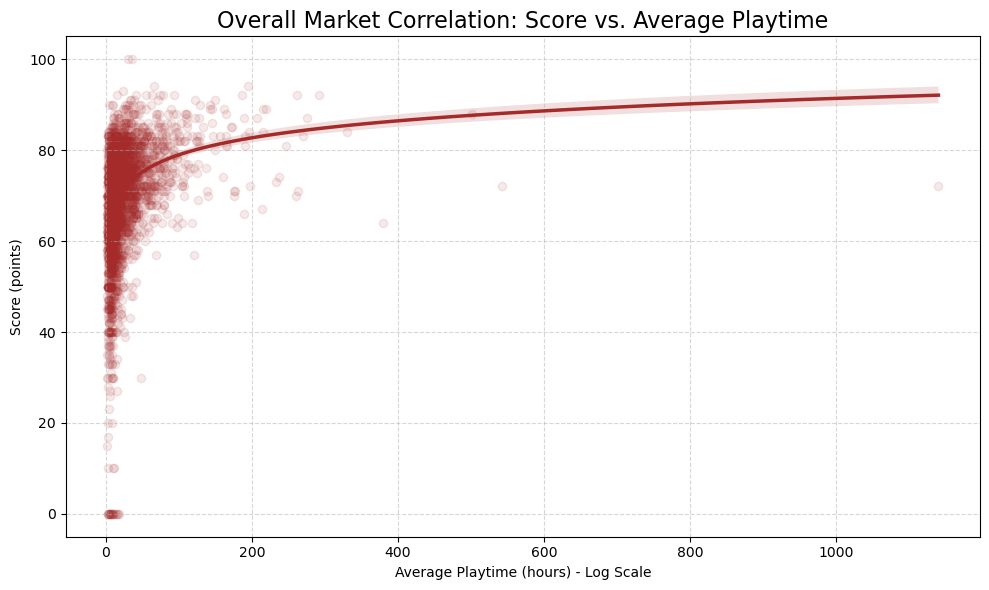

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# -----------------------------------------------------------------
# 重置字体设置
# -----------------------------------------------------------------
plt.rcParams.update(plt.rcParamsDefault)


def plot_overall_correlation_orange(file_path, min_sample_size=20):
    """
    绘制 'score' vs 'meantime' 的 *总体* 相关性散点图。
    - 主题色改为橙色
    - X轴使用对数刻度 (log scale)
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"错误：找不到文件 '{file_path}'")
        return
    except Exception as e:
        print(f"加载CSV时出错: {e}")
        return

    # --- 1. 数据清洗和准备 ---
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df['meantime'] = pd.to_numeric(df['meantime'], errors='coerce')
    df_clean = df[['genre', 'score', 'meantime']].dropna()

    # --- 2. 筛选出样本量足够的组 (逻辑同前) ---
    genre_counts = df_clean['genre'].value_counts()
    valid_genres = genre_counts[genre_counts >= min_sample_size].index
    
    if len(valid_genres) < 2:
        print(f"Error: Less than two 'genre' groups found with sample size >= {min_sample_size}.")
        return

    df_filtered = df_clean[df_clean['genre'].isin(valid_genres)]

    print(f"--- 正在为 *所有* {len(df_filtered)} 个游戏生成 *橙色主题* 总体相关性图表 ---")

    # --- 绘制 regplot (回归图) ---
    plt.figure(figsize=(10, 6)) # 创建一个画布
    
    # -----------------------------------------------------------------
    # 步骤3: 应用橙色主题
    # -----------------------------------------------------------------
    sns.regplot(
        data=df_filtered,
        x='meantime',
        y='score',
        logx=True,        # <-- 关键：X轴使用对数刻度
        
        # 将趋势线改为深橙色
        line_kws={'color': 'brown', 'linewidth': 2.5}, 
        
        # 将散点改为橙色，并保持低透明度以显示密度
        scatter_kws={'alpha':0.1, 'color': 'brown'} 
    )
    # -----------------------------------------------------------------
    
    # --- 设置英文标签 ---
    plt.title('Overall Market Correlation: Score vs. Average Playtime', fontsize=16)
    plt.xlabel('Average Playtime (hours) - Log Scale') # X轴
    plt.ylabel('Score (points)')                 # Y轴
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show() # 显示图表

# --- 执行 ---
plot_overall_correlation_orange('comdata.csv')

In [29]:
import pandas as pd
from scipy import stats

def calculate_both_correlations(file_path, min_sample_size=20):
    """
    加载数据，并为每个 genre 分别计算 'score' 和 'meantime' 
    之间的 *Spearman (斯皮尔曼)* 和 *Pearson (皮尔逊)* 相关系数。
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"错误：找不到文件 '{file_path}'")
        return
    except Exception as e:
        print(f"加载CSV时出错: {e}")
        return

    # --- 1. 数据清洗和准备 ---
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df['meantime'] = pd.to_numeric(df['meantime'], errors='coerce')
    df_clean = df[['genre', 'score', 'meantime']].dropna()

    # --- 2. 筛选出样本量足够的组 ---
    genre_counts = df_clean['genre'].value_counts()
    valid_genres = genre_counts[genre_counts >= min_sample_size].index
    df_filtered = df_clean[df_clean['genre'].isin(valid_genres)]

    print(f"--- 正在为 {len(valid_genres)} 个 'genre' (n >= {min_sample_size}) 计算相关性 ---")

    results_list = []

    # --- 3. 循环计算每个 genre 的相关性 ---
    for g in valid_genres:
        df_genre = df_filtered[df_filtered['genre'] == g]
        
        if len(df_genre) < 3:
            continue
            
        # 1. 计算 Spearman (斯皮尔曼) - 正确的方法
        rho_s, p_s = stats.spearmanr(df_genre['score'], df_genre['meantime'])
        
        # 2. 计算 Pearson (皮尔逊) - 错误的方法 (仅供对比)
        # 注意: stats.pearsonr 返回 (rho, p_value)
        rho_p, p_p = stats.pearsonr(df_genre['score'], df_genre['meantime'])
        
        results_list.append({
            'Genre': g,
            'Spearman_rho (ρ)': rho_s,
            'Spearman_p_value': p_s,
            'Pearson_rho (r)': rho_p,
            'Pearson_p_value': p_p,
            'Sample_Size (n)': len(df_genre)
        })

    # --- 4. 整理并打印结果 ---
    if not results_list:
        print("没有足够的数据来计算相关性。")
        return

    results_df = pd.DataFrame(results_list)
    
    # 按 Spearman 结果排序
    results_df_sorted = results_df.sort_values(by='Spearman_rho (ρ)', ascending=False)
    
    print("\n" + "="*80)
    print("      'Score' vs. 'Meantime' 相关性对比 (Spearman vs Pearson)")
    print("="*80)
    print(results_df_sorted.to_string(index=False, float_format="%.4f"))
    print("="*80)


# --- 执行 ---
calculate_both_correlations('comdata.csv')

--- 正在为 12 个 'genre' (n >= 20) 计算相关性 ---

      'Score' vs. 'Meantime' 相关性对比 (Spearman vs Pearson)
       Genre  Spearman_rho (ρ)  Spearman_p_value  Pearson_rho (r)  Pearson_p_value  Sample_Size (n)
        Misc            0.5371            0.0000           0.2697           0.0029              120
      Action            0.5236            0.0000           0.4059           0.0000              670
   Adventure            0.4962            0.0000           0.4363           0.0000              130
    Platform            0.4509            0.0000           0.3779           0.0000              244
     Shooter            0.4481            0.0000           0.1361           0.0111              347
Role-Playing            0.4338            0.0000           0.3751           0.0000              345
  Simulation            0.4287            0.0000           0.2340           0.0179              102
      Racing            0.4008            0.0000           0.3068           0.0000              209
 

--- Generating English plot for 12 genres ---


C:\Users\50590\AppData\Local\Temp\ipykernel_23164\3927551808.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


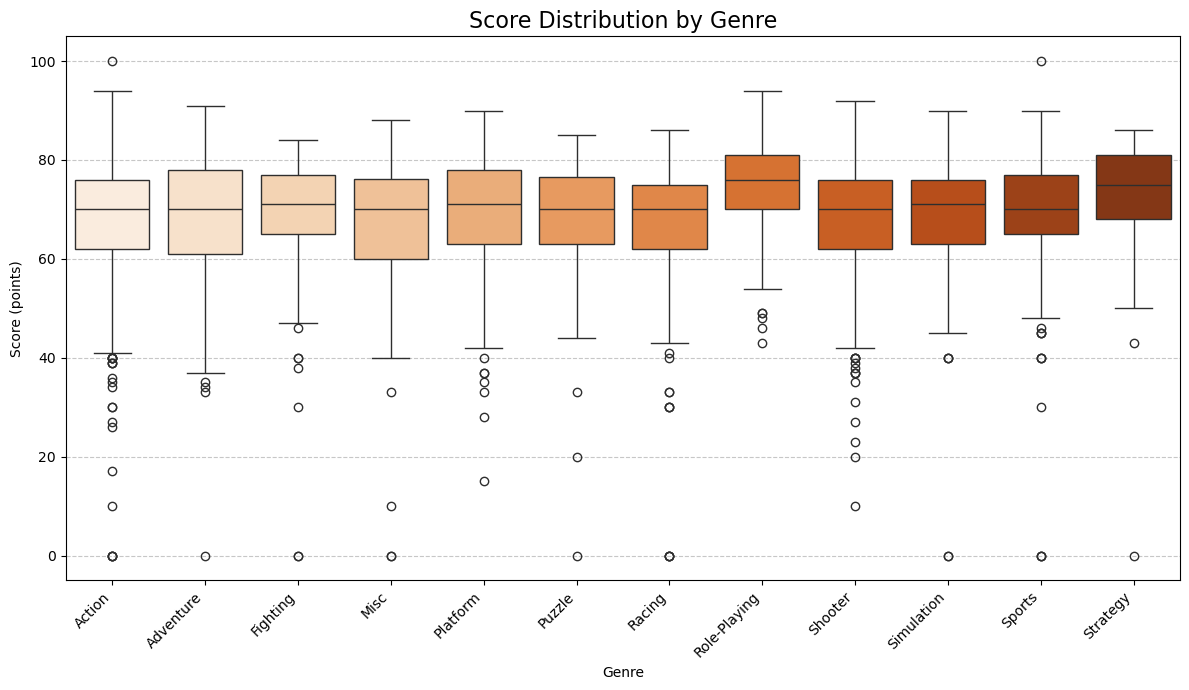

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# -----------------------------------------------------------------
# 步骤1: 重置字体设置
# -----------------------------------------------------------------
plt.rcParams.update(plt.rcParamsDefault)


def plot_english_boxplot(file_path, min_sample_size=20):
    """
    加载数据并绘制一个全英文、美化后的“橙色主题”箱线图。
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"错误：找不到文件 '{file_path}'")
        return
    except Exception as e:
        print(f"加载CSV时出错: {e}")
        return

    # --- 1. 数据清洗 ---
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df_clean = df[['genre', 'score']].dropna()

    # --- 2. 筛选样本量足够的 genre ---
    genre_counts = df_clean['genre'].value_counts()
    valid_genres = genre_counts[genre_counts >= min_sample_size].index
    
    if len(valid_genres) < 2:
        print(f"Error: Less than two 'genre' groups found with sample size >= {min_sample_size}.")
        return

    df_filtered = df_clean[df_clean['genre'].isin(valid_genres)]
    df_filtered = df_filtered.sort_values('genre')

    print(f"--- Generating English plot for {len(valid_genres)} genres ---")

    # --- 绘制箱线图 (Box Plot) ---
    plt.figure(figsize=(12, 7))

    sns.boxplot(
        x='genre',
        y='score',
        data=df_filtered,
        palette='Oranges'   # 保持橙色主题
    )

    # --- 设置英文标签 ---
    plt.title('Score Distribution by Genre', fontsize=16)
    plt.ylabel('Score (points)')
    plt.xlabel('Genre')

    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# --- 执行 ---
plot_english_boxplot('comdata.csv')
